In [1]:
# Instalación de librerías
%pip install "stable-baselines3[extra]" gymnasium

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/952.1 kB ? eta -:--:--
   ---------------------------------------- 952.1/952.1 kB 9.8 MB/s  0:00:00
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   -- ------------------------------------- 6.3/110.9 MB 30.6 MB/s eta 0:00:04
   ------- -----------------------

In [8]:
# Importación de dependencias necesarias
import numpy as np
import joblib
from envs.attack_env import AttackEnv
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

In [ ]:
# Clase callback personalizada para logear y graficar
class AttackLoggerCallback(BaseCallback): # Extiende BaseCallback de stable-baselines3

    def __init__(self, log_freq: int = 1000, verbose: int = 0): # Muestra estadísticas cada 1000 episodios y pone el nivel de verbosidad a 0 por defecto (no muestra nada)
        super().__init__(verbose)
        self.log_freq = log_freq # Muestra estadísticas cada log_freq episodios
        self.episode_count = 0 # Contador de episodios completados

        # Buffers por ventana (1000 episodios)
        self.rewards_buffer = [] # Buffer para recompensas
        self.success_buffer = [] # Buffer de veces que tuvo éxito
        self.p_attack_buffer = [] # Buffer de probabilidades de que el detector detecte el ataque

        # histórico para graficar
        self.history_episodes = []
        self.history_mean_reward = []
        self.history_success_rate = []
        self.history_mean_p_attack = []

    def _on_step(self) -> bool:
        infos = self.locals["infos"]
        rewards = self.locals["rewards"]
        dones = self.locals["dones"]

        for info, r, done in zip(infos, rewards, dones):
            if done:
                self.episode_count += 1
                self.rewards_buffer.append(float(r))

                if "success" in info:
                    self.success_buffer.append(int(info["success"]))
                if "p_attack" in info:
                    self.p_attack_buffer.append(float(info["p_attack"]))

        if self.episode_count > 0 and self.episode_count % self.log_freq == 0:
            mean_reward = np.mean(self.rewards_buffer) if self.rewards_buffer else 0.0
            success_rate = np.mean(self.success_buffer) if self.success_buffer else 0.0
            mean_p_attack = np.mean(self.p_attack_buffer) if self.p_attack_buffer else 0.0

            # guardar en histórico
            self.history_episodes.append(self.episode_count)
            self.history_mean_reward.append(mean_reward)
            self.history_success_rate.append(success_rate)
            self.history_mean_p_attack.append(mean_p_attack)

            print(
                f"[AttackLogger] Episodios: {self.episode_count:6d} | "
                f"Reward medio: {mean_reward: .3f} | "
                f"Tasa éxito: {success_rate*100:5.1f}% | "
                f"p_attack media: {mean_p_attack: .3f}"
            )

            # Limpiamos los buffers para la siguiente ventana
            self.rewards_buffer.clear()
            self.success_buffer.clear()
            self.p_attack_buffer.clear()

        return True


In [3]:
# Carga del dataset
data = np.load("../data/synthetic_2d.npz")
X_train, X_test = data["X_train"], data["X_test"]
y_train, y_test = data["y_train"], data["y_test"]

# Cargamos solo muestras de ataque para el entorno
attack_mask = y_train == 1 # Crea un array booleano a true para muestras de ataque
attack_samples = X_train[attack_mask] # Nos quedamos solo con las muestras de ataque

# Imprimimos la forma de las muestras de ataque
print("Attack samples:", attack_samples.shape)

# Carga del modelo clasificador
clf = joblib.load("../classifiers/logreg_synthetic_2d.joblib")

Attack samples: (800, 2)


In [4]:
# Creación del entorno
env = AttackEnv(
    attack_samples=attack_samples, # Lista de todas las muestras de ataque
    clf=clf, # Modelo clasificador
    threshold=0.5, # A partid de de esta probabilidad se considera que es ataque
    epsilon=0.5, # Distancia máxima que el agente puede mofificar el punto original
    penalty=0.05, # Penalización por moverse mucho
)

In [10]:
# Constucción y entrenamiento del agente PPO (RL)
policy_kwargs = dict(net_arch=[64, 64]) # Arquitectura de la red neuronal, dos capas ocultas de 64 neuronas cada una

model = PPO(
    "MlpPolicy",
    env, # Ligamos el modelo con el entorno
    verbose=0, # Indica imprimir información báscica del entrenamiento (1) o no (0)
    policy_kwargs=policy_kwargs, # Le pasamos la arquiectura definida para la red neuronal
    n_steps=2048, # Número de pasos a ejecutar antes de cada actualización de política
    batch_size=64,  # Los grupos en los que se divide cada actualización
    learning_rate=3e-4, # Tasa de aprendizaje, qué tanto se actualizan los pesos de la red neuronal en cada paso
)

# Creación del callback personalizado para logging
callback = AttackLoggerCallback(log_freq=1000)

# Entrenamiento del agente de 100,000 pasos y uso del callback para logging
model.learn(total_timesteps=200_000, callback=callback)

# Guardado del modelo entrenado
model.save("../agents/ppo_attacker_synthetic_2d")

[AttackLogger] Episodios:   1000 | Reward medio:  0.003 | Tasa éxito:   2.2% | p_attack media:  0.965
[AttackLogger] Episodios:   2000 | Reward medio: -0.000 | Tasa éxito:   1.8% | p_attack media:  0.969
[AttackLogger] Episodios:   3000 | Reward medio:  0.001 | Tasa éxito:   2.0% | p_attack media:  0.963
[AttackLogger] Episodios:   4000 | Reward medio:  0.009 | Tasa éxito:   2.8% | p_attack media:  0.954
[AttackLogger] Episodios:   5000 | Reward medio:  0.010 | Tasa éxito:   2.8% | p_attack media:  0.959
[AttackLogger] Episodios:   6000 | Reward medio:  0.004 | Tasa éxito:   2.2% | p_attack media:  0.961
[AttackLogger] Episodios:   7000 | Reward medio:  0.016 | Tasa éxito:   3.4% | p_attack media:  0.950
[AttackLogger] Episodios:   8000 | Reward medio:  0.026 | Tasa éxito:   4.4% | p_attack media:  0.942
[AttackLogger] Episodios:   9000 | Reward medio:  0.014 | Tasa éxito:   3.2% | p_attack media:  0.953
[AttackLogger] Episodios:  10000 | Reward medio:  0.017 | Tasa éxito:   3.5% | p_a

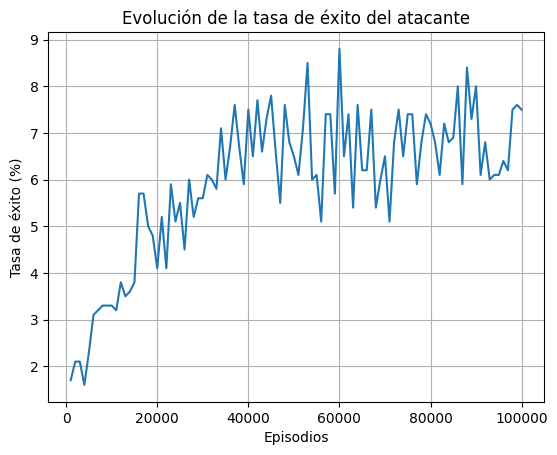

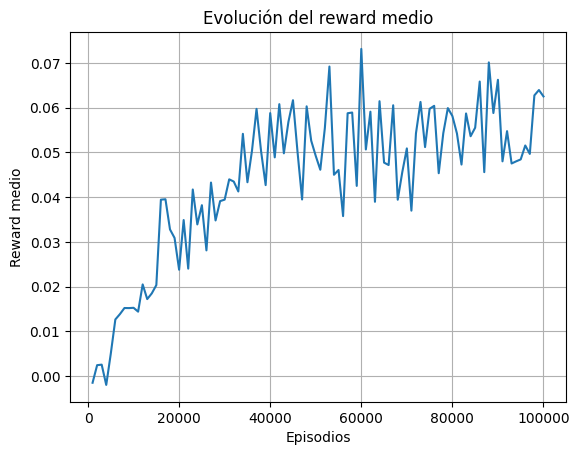

In [ ]:
# Gráfica de tasa de éxito
plt.figure()
plt.plot(callback.history_episodes, [sr * 100 for sr in callback.history_success_rate])
plt.xlabel("Episodios")
plt.ylabel("Tasa de éxito (%)")
plt.title("Evolución de la tasa de éxito del atacante")
plt.grid(True)
plt.show()

# (Opcional) Reward medio
plt.figure()
plt.plot(callback.history_episodes, callback.history_mean_reward)
plt.xlabel("Episodios")
plt.ylabel("Reward medio")
plt.title("Evolución del reward medio")
plt.grid(True)
plt.show()

In [11]:
# Evaluar al atacante
def evaluate_attacker(model, env, n_episodes=1000):
    successes = 0
    deltas_norm = []

    obs, info = env.reset()
    for _ in range(n_episodes):
        action, _ = model.predict(obs, deterministic=True)
        next_obs, reward, terminated, truncated, info = env.step(action)

        if info["success"] == 1:
            successes += 1

        delta = info["x_adv"] - info["x_orig"]
        deltas_norm.append(np.linalg.norm(delta))

        if terminated or truncated:
            obs, info = env.reset()
        else:
            obs = next_obs

    success_rate = successes / n_episodes
    mean_delta = float(np.mean(deltas_norm))
    return success_rate, mean_delta

success_rate, mean_delta = evaluate_attacker(model, env, n_episodes=2000)
print(f"Tasa de evasión: {success_rate:.3f}")
print(f"Norma media de la perturbación: {mean_delta:.3f}")


Tasa de evasión: 0.068
Norma media de la perturbación: 0.299


In [12]:
# Comparar con un atacante random
def evaluate_random_attacker(env, n_episodes=1000):
    successes = 0
    deltas_norm = []

    obs, info = env.reset()
    for _ in range(n_episodes):
        action = env.action_space.sample()
        next_obs, reward, terminated, truncated, info = env.step(action)

        if info["success"] == 1:
            successes += 1

        delta = info["x_adv"] - info["x_orig"]
        deltas_norm.append(np.linalg.norm(delta))

        if terminated or truncated:
            obs, info = env.reset()
        else:
            obs = next_obs

    success_rate = successes / n_episodes
    mean_delta = float(np.mean(deltas_norm))
    return success_rate, mean_delta

rand_success, rand_delta = evaluate_random_attacker(env, n_episodes=2000)
print(f"[Random] Tasa de evasión: {rand_success:.3f}")
print(f"[Random] Norma media de la perturbación: {rand_delta:.3f}")

[Random] Tasa de evasión: 0.013
[Random] Norma media de la perturbación: 0.382
